## 1. Read the data

In [244]:
# Read the data 
import pandas as pd
data_df = pd.read_csv('data/insurance.csv')
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Data cleaning

In [245]:
# Check for missing values
data_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Luckily we have no missing data, proceeding to look at distribution of numerical and categorical features

In [246]:
# check for distribution of numerical features
data_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [247]:
# get summary of categorical features
data_df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


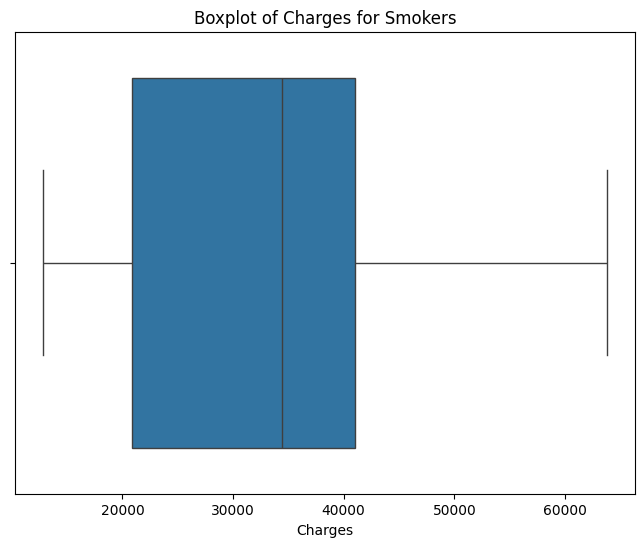

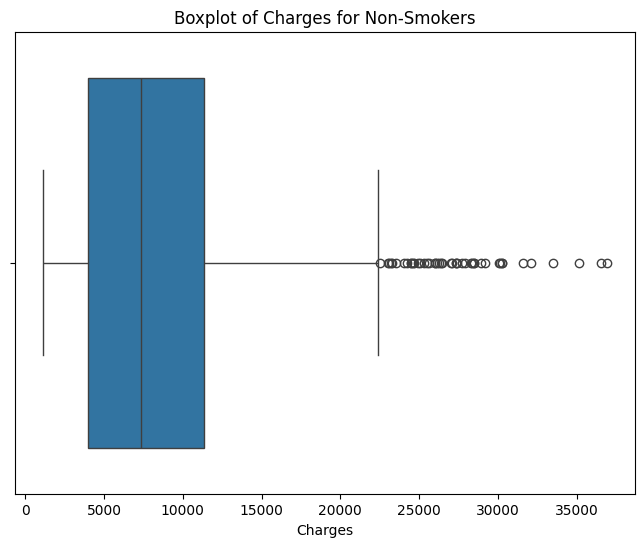

In [248]:
# Identify outliers in charges for smokers and non-smokers separately
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(x=smoker_df['charges'])
plt.title('Boxplot of Charges for Smokers')
plt.xlabel('Charges')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=non_smoker_df['charges'])
plt.title('Boxplot of Charges for Non-Smokers')
plt.xlabel('Charges')
plt.show()

The data looks skewed towards non-smokers over smokers.  Proceeding to look at the correlation matrix.

Number of outliers in charges for non-smoker group: 46


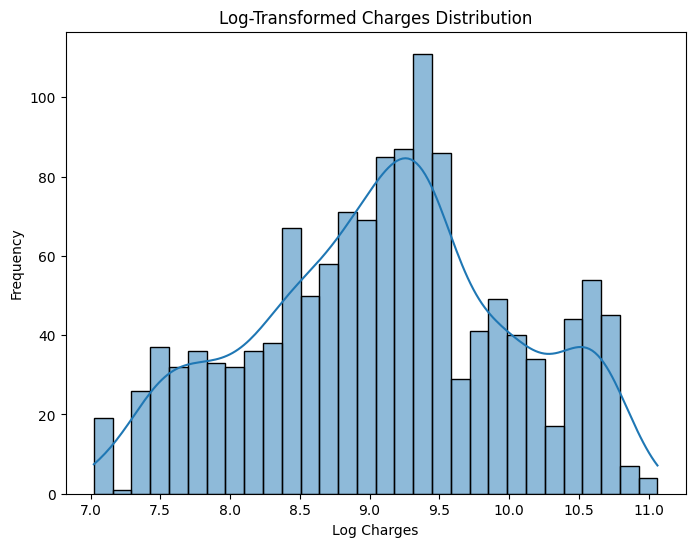

(1292, 8)

In [249]:
# count the number of outliers in charges for non-smoker group
Q1 = non_smoker_df['charges'].quantile(0.25)
Q3 = non_smoker_df['charges'].quantile(0.75)
IQR = Q3 - Q1
outliers = non_smoker_df[(non_smoker_df['charges'] < (Q1 - 1.5 * IQR)) | (non_smoker_df['charges'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers in charges for non-smoker group: {outliers.shape[0]}')
# Log transform the charges to reduce skewness
import numpy as np
data_df['log_charges'] = np.log1p(data_df['charges'])
plt.figure(figsize=(8, 6))
sns.histplot(data_df['log_charges'], bins=30, kde=True)
plt.title('Log-Transformed Charges Distribution')
plt.xlabel('Log Charges')
plt.ylabel('Frequency')
plt.show()
# Drop the outliers from non-smoker group
data_df = data_df[~data_df.index.isin(outliers.index)]
data_df.reset_index(drop=True, inplace=True)
data_df.shape

## 3. Plotting, scaling, normalizing

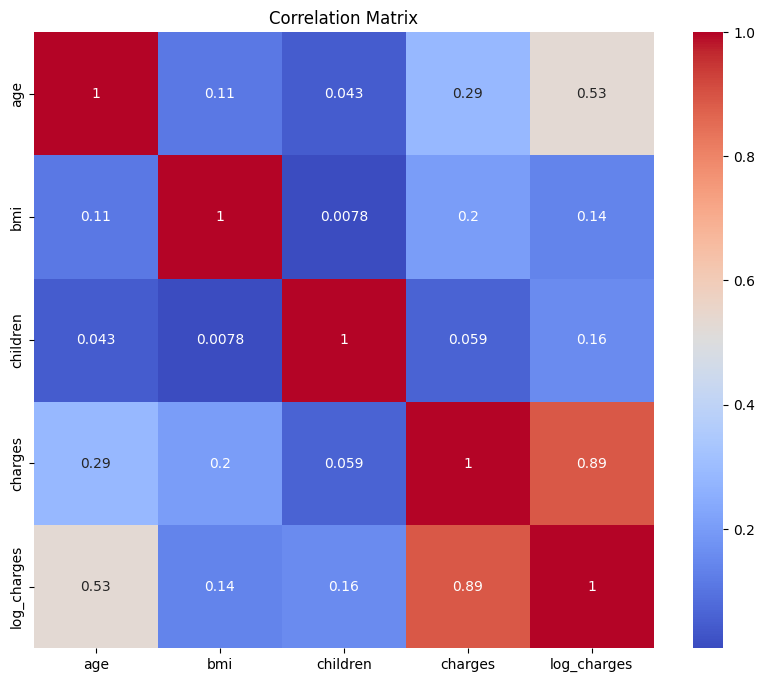

In [250]:
# plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# only numerical features are considered for correlation
numerical_features = data_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

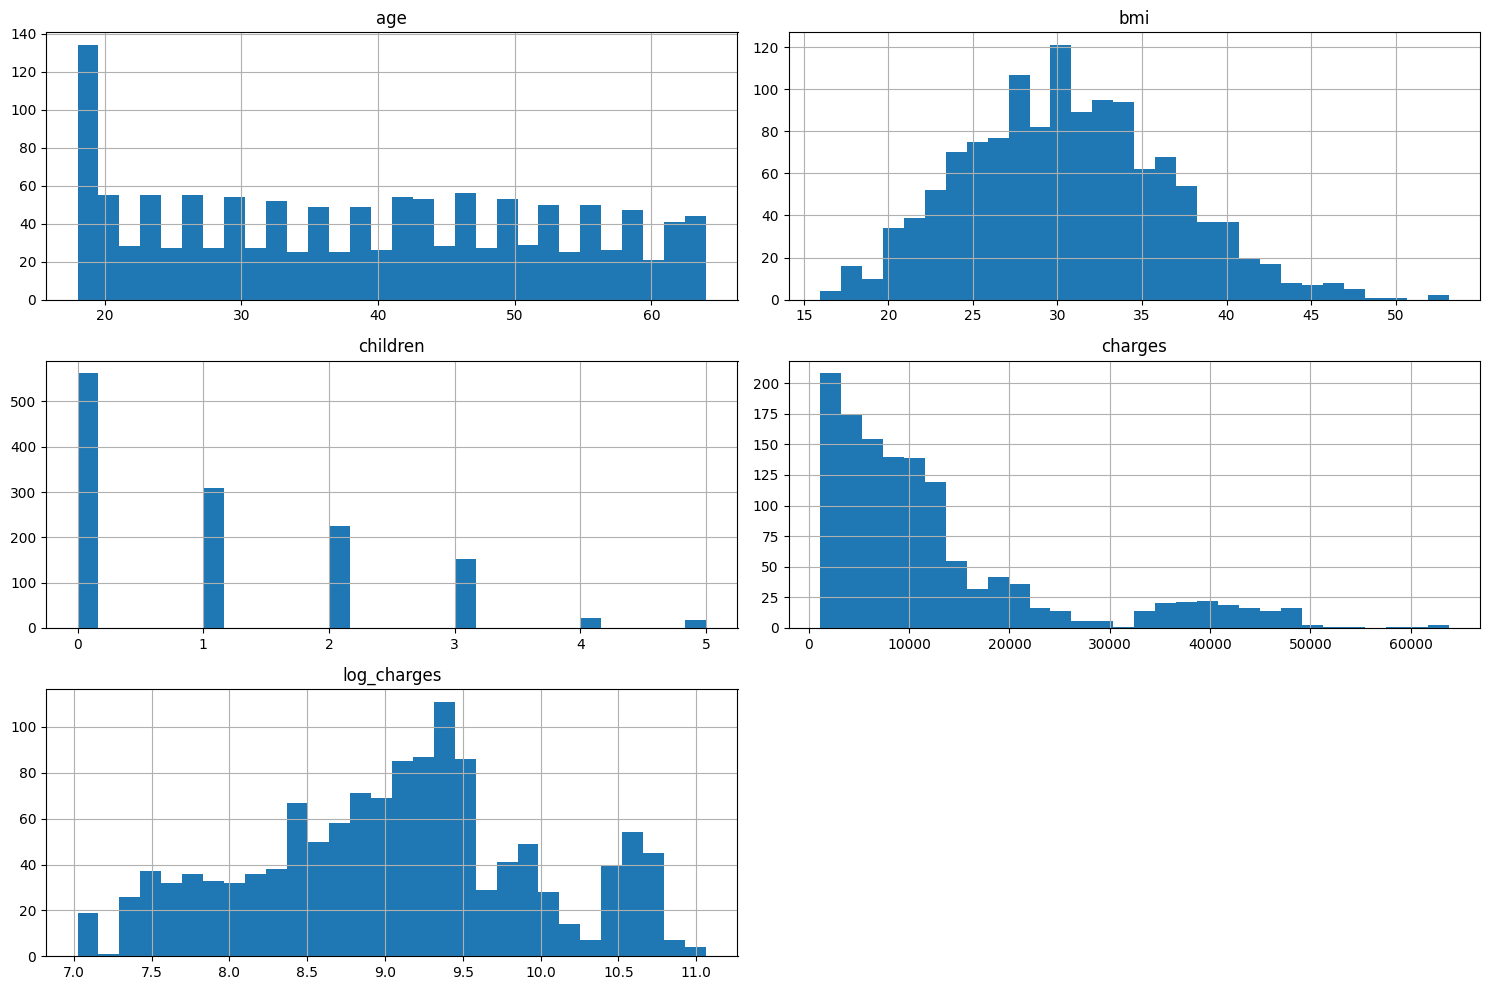

In [251]:
# plot a grid of histograms of charges and the other features to see their distributions
data_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

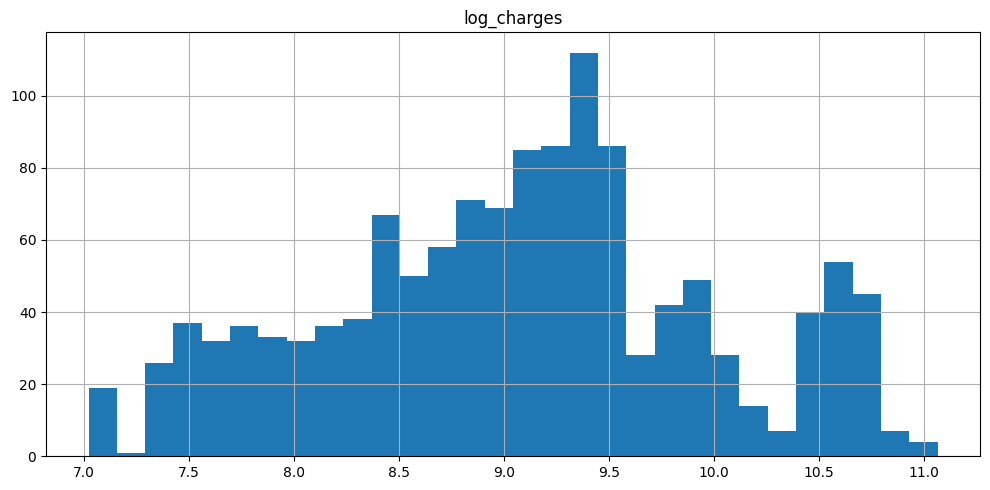

In [252]:
# Since age and charges are right skewed, we can apply log transformation to them
import numpy as np
data_df['log_charges'] = np.log(data_df['charges'])
data_df[['log_charges']].hist(bins=30, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [253]:
# Drop the original charges column
data_df = data_df.drop(columns=['charges'])

In [254]:
# normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['age', 'bmi']
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])
data_df.head()

,age,sex,bmi,children,smoker,region,log_charges
0,-1.426073,female,-0.449927,0,yes,southwest,9.734176
1,-1.497543,male,0.507786,1,no,southeast,7.453302
2,-0.782847,male,0.382157,3,no,southeast,8.400538
3,-0.425499,male,-1.297510,0,no,northwest,9.998092
4,-0.496968,male,-0.290036,0,no,northwest,8.260197


## 4. Baseline model - Simple linear regression

In [255]:
# model the relationship between charges (y) and the other features (X) using simple linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
X = data_df.drop('log_charges', axis=1)
y = data_df['log_charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 10 fold cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV: {r2_scores.mean()}')
# Fit the model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

Average MSE from 10-fold CV: 0.15534187482359768
Average R2 from 10-fold CV: 0.8021928949660054
Test MSE: 0.1323511843813415
Test R2: 0.8459414504333729


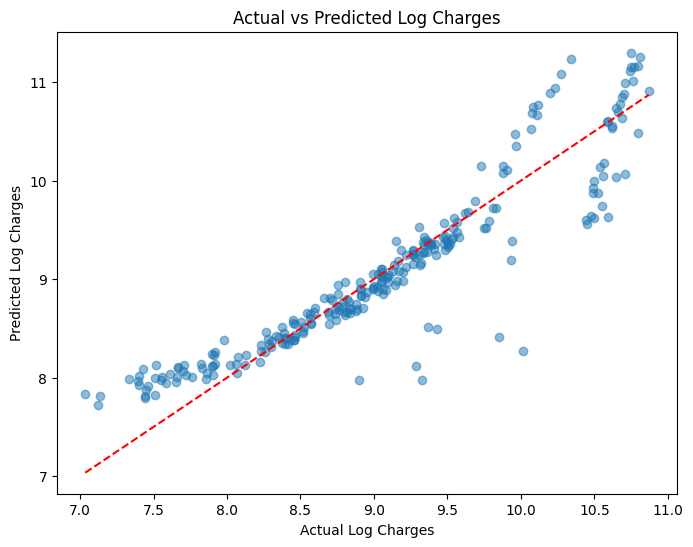

In [256]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

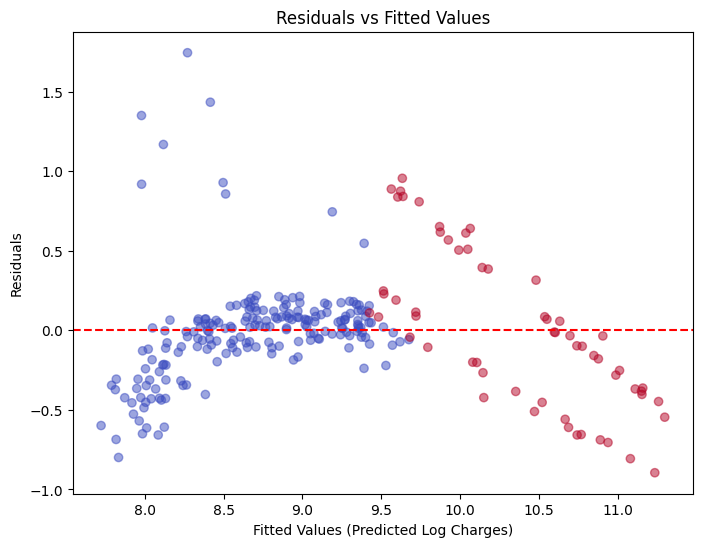

In [257]:
# plot residuals vs fitted values
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, c=data_df.loc[y_test.index, 'smoker'].map({'yes': 1, 'no': 0}), cmap='coolwarm')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Now that we have a baseline, we can explore more complex models and feature engineering techniques to improve performance.

## 5. Feature engineering and other approaches

###  5.1 Adding interaction terms and running Linear Regression again

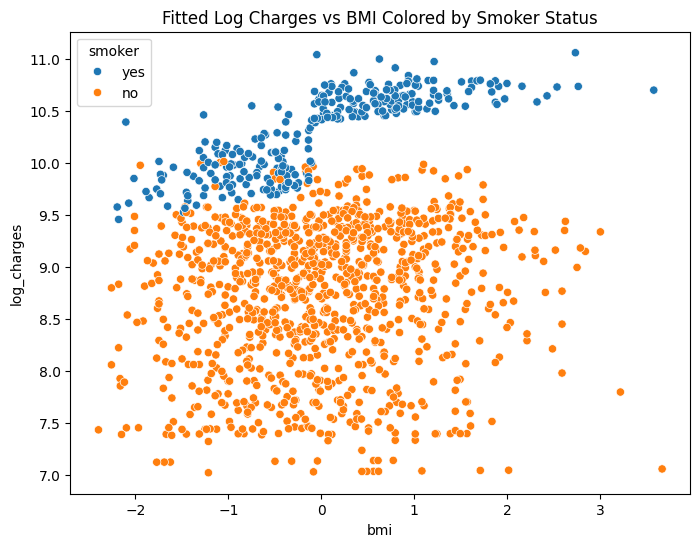

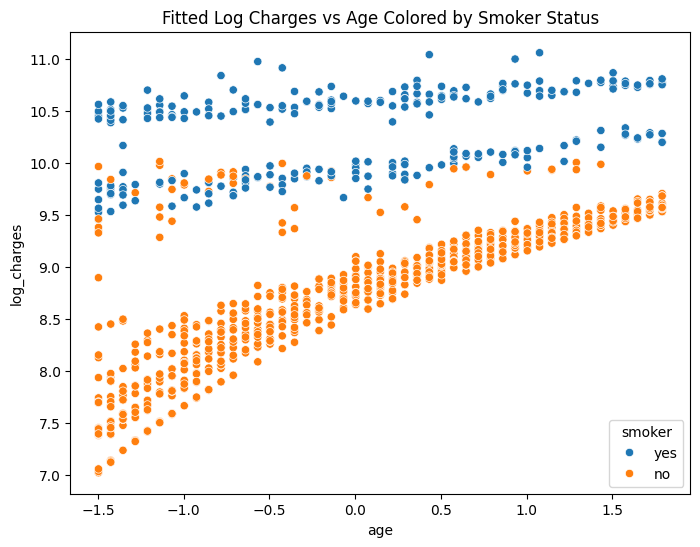

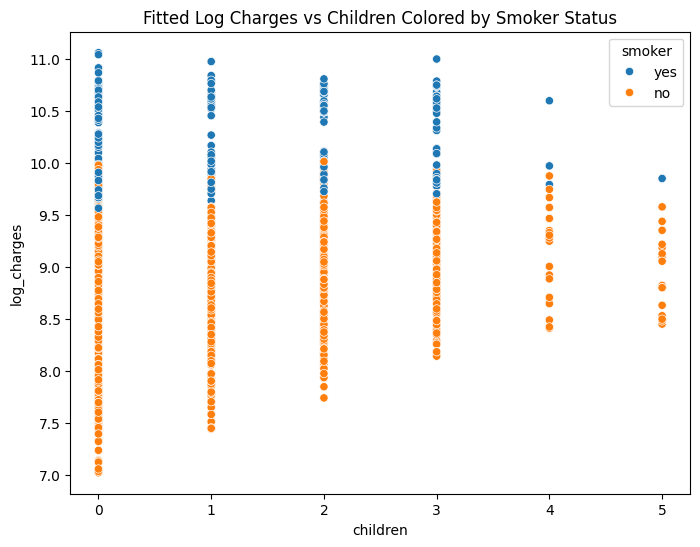

In [258]:
# Since smoker is the most important feature, plot a scatter plot of fitted charges vs each numerical feature colored by smoker status
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs BMI Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs Age Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='children', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs Children Colored by Smoker Status')
plt.show()

From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, so considering a split in this group as a new feature and adding an interaction term between the new feature and smoker in the new model

In [259]:
# From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, 
# so considering a split in this group as a new feature and 
# adding an interaction term between the new feature and smoker in the new model   
data_df['high_bmi'] = (data_df['bmi'] > 30).astype(int)
data_df['high_bmi_smoker_interaction'] = data_df['high_bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df['high_bmi_bmi_interaction'] = data_df['high_bmi'] * data_df['bmi']
data_df['bmi_smoker_interaction'] = data_df['bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df.drop(['high_bmi'], axis=1, inplace=True)
# Re-define features and target variable with the new feature
X = data_df.drop('log_charges', axis=1)
y = data_df['log_charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Use 10 fold cross-validation to evaluate the new model
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV after adding high_bmi_smoker feature: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV after adding high_bmi_smoker feature: {r2_scores.mean()}')
# Fit the new model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the new model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE after adding high_bmi_smoker feature: {mse}')
print(f'Test R2 after adding high_bmi_smoker feature: {r2}')

Average MSE from 10-fold CV after adding high_bmi_smoker feature: 0.14305500167998203
Average R2 from 10-fold CV after adding high_bmi_smoker feature: 0.8184074671078381
Test MSE after adding high_bmi_smoker feature: 0.11578235653866902
Test R2 after adding high_bmi_smoker feature: 0.8652277877441641


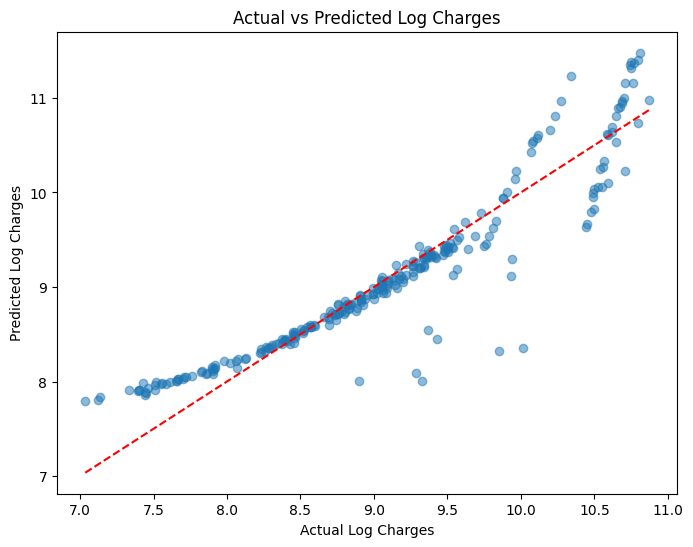

In [260]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

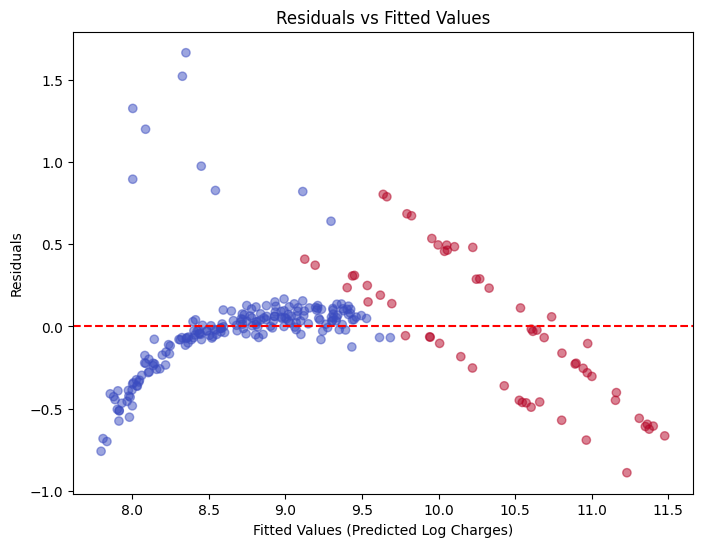

In [261]:
# plot residuals vs fitted values
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, c=data_df.loc[y_test.index, 'smoker'].map({'yes': 1, 'no': 0}), cmap='coolwarm')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We have a better fit now with the inclusion of the new feature, our test R2 has gone up from 0.8047311493462986 to 0.8169560889305182

### 5.2 Random Forest with hyperparameter tuning

In [262]:
# Try using a Random Forest with hyperparameter tuning to see if we can improve the model performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 11, 1),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
# Predict on the test data using the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Test MSE: {mse_rf}')
print(f'Random Forest Test R2: {r2_rf}')

Random Forest Test MSE: 0.06760374428447521
Random Forest Test R2: 0.9213083370698746


### 5.3 LightGBM with hyperparameter tuning

In [263]:
# use LightGBM to see if we can improve the model performance further
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
# specify your configurations as a dict
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval)
# predict
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# evaluate
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'LightGBM Test MSE: {mse_lgb}')
print(f'LightGBM Test R2: {r2_lgb}')

LightGBM Test MSE: 0.06389423514168062
LightGBM Test R2: 0.9256262553477834


### 5.4 XGBoost with hyperparameter tuning

In [264]:
# Run XGBoost to see if we can improve the model performance further using GridSearchCV for hyperparameter tuning
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 11, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
# Predict on the test data using the best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Test MSE: {mse_xgb}')
print(f'XGBoost Test R2: {r2_xgb}')

XGBoost Test MSE: 0.05824654594939071
XGBoost Test R2: 0.932200241137441


The XGBoost algorithm has the best R2 of all algorithms so far, looking for opportunities to improve the model further.

### 5.5 Revisiting scatter plots

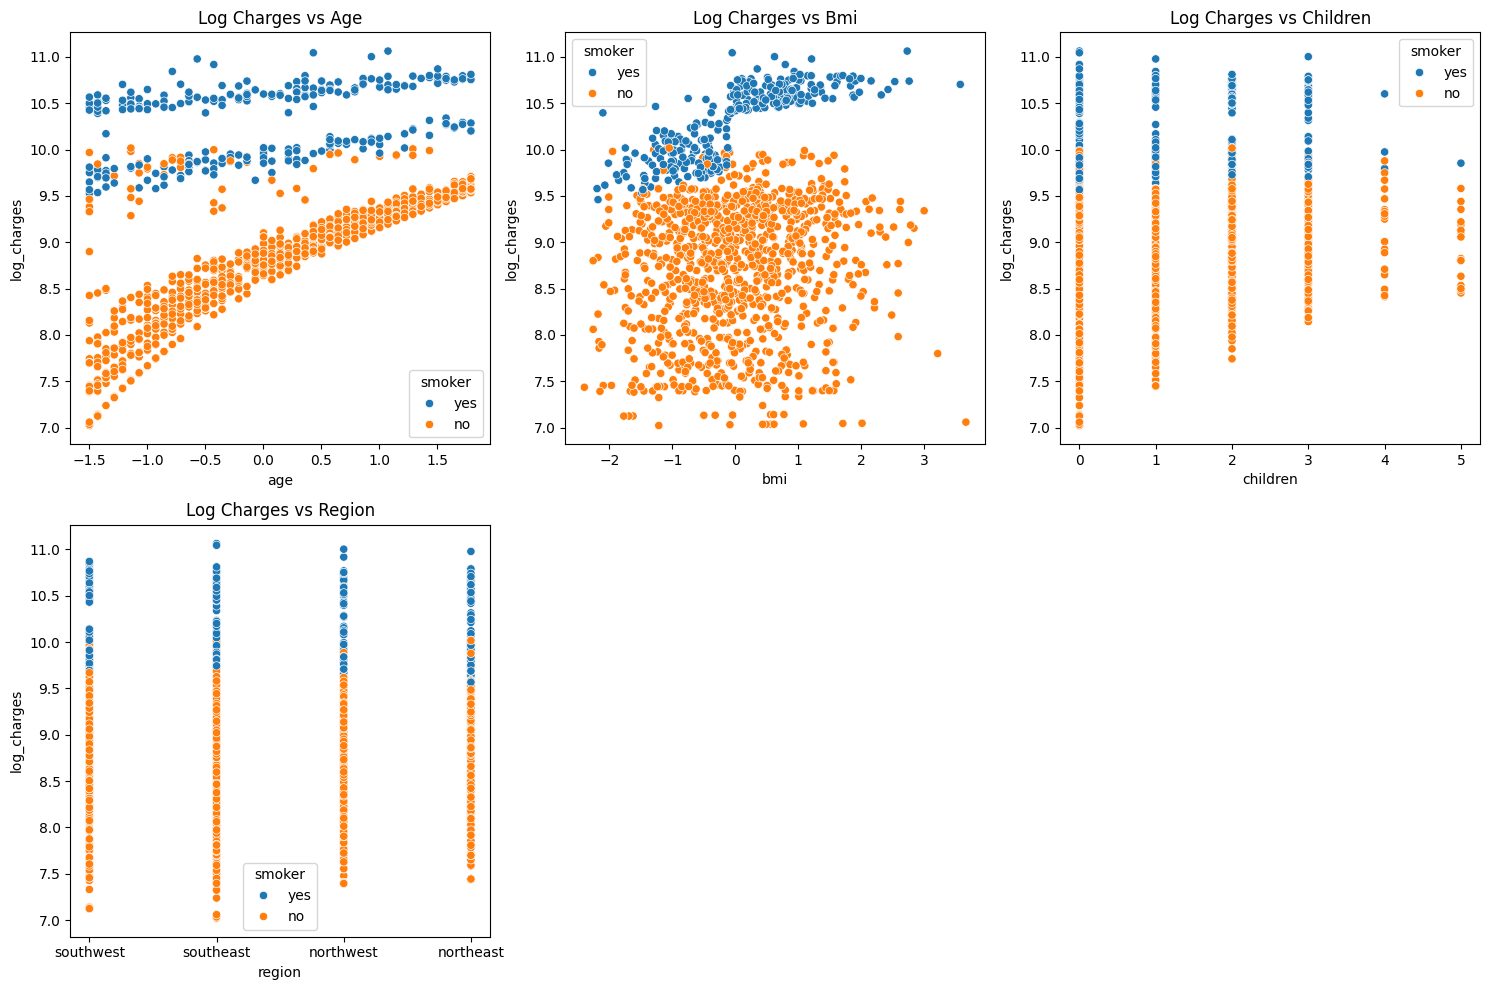

In [265]:
# create a grid of scatter plots of charges vs each of the input features to explore higher order interactions
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 10))

# Create a grid of scatter plots
features = ['age', 'bmi', 'children', 'region']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='log_charges', data=data_df, hue='smoker')
    plt.title(f'Log Charges vs {feature.capitalize()}')

plt.tight_layout()
plt.show()

### 5.6 Splitting data as smoker and non-smoker, fitting separate models

In [266]:
# Split the data into smoker and non-smoker groups and analyze the model performance separately
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']
# Define features and target variable for smoker group
X_smoker = smoker_df.drop('log_charges', axis=1)
y_smoker = smoker_df['log_charges']
# One-hot encode categorical variables
X_smoker = pd.get_dummies(X_smoker, drop_first=True)
# Use train-test split
X_train_smoker, X_test_smoker, y_train_smoker, y_test_smoker = train_test_split(X_smoker, y_smoker, test_size=0.2, random_state=42)


# Use hyperparameter tuning to find the best XGBoost model for smoker group
xgb_model_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_smoker = {
    'n_estimators': [20,50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_search_xgb_smoker = GridSearchCV(estimator=xgb_model_smoker, param_grid=param_grid_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_smoker.fit(X_train_smoker, y_train_smoker)
best_xgb_smoker = grid_search_xgb_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for smoker group
y_pred_xgb_smoker = best_xgb_smoker.predict(X_test_smoker)
# Evaluate the XGBoost model for smoker group
mse_xgb_smoker = mean_squared_error(y_test_smoker, y_pred_xgb_smoker)
r2_xgb_smoker = r2_score(y_test_smoker, y_pred_xgb_smoker)
print(f'XGBoost Test MSE for Smoker Group: {mse_xgb_smoker}')
print(f'XGBoost Test R2 for Smoker Group: {r2_xgb_smoker}') 

XGBoost Test MSE for Smoker Group: 0.013630194037895069
XGBoost Test R2 for Smoker Group: 0.9146997559751213


In [267]:
# do the same for non-smoker group
# Define features and target variable for non-smoker group
X_non_smoker = non_smoker_df.drop('log_charges', axis=1)
y_non_smoker = non_smoker_df['log_charges']
# One-hot encode categorical variables
X_non_smoker = pd.get_dummies(X_non_smoker, drop_first=True)
# Use train-test split
X_train_non_smoker, X_test_non_smoker, y_train_non_smoker, y_test_non_smoker = train_test_split(X_non_smoker, y_non_smoker, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for non-smoker group
xgb_model_non_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker = GridSearchCV(estimator=xgb_model_non_smoker, param_grid=param_grid_non_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker.fit(X_train_non_smoker, y_train_non_smoker)
best_xgb_non_smoker = grid_search_xgb_non_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group
y_pred_xgb_non_smoker = best_xgb_non_smoker.predict(X_test_non_smoker)
# Evaluate the XGBoost model for non-smoker group
mse_xgb_non_smoker = mean_squared_error(y_test_non_smoker, y_pred_xgb_non_smoker)
r2_xgb_non_smoker = r2_score(y_test_non_smoker, y_pred_xgb_non_smoker)
print(f'XGBoost Test MSE for Non-Smoker Group: {mse_xgb_non_smoker}')
print(f'XGBoost Test R2 for Non-Smoker Group: {r2_xgb_non_smoker}')

XGBoost Test MSE for Non-Smoker Group: 0.07582782144213594
XGBoost Test R2 for Non-Smoker Group: 0.8315492897884069


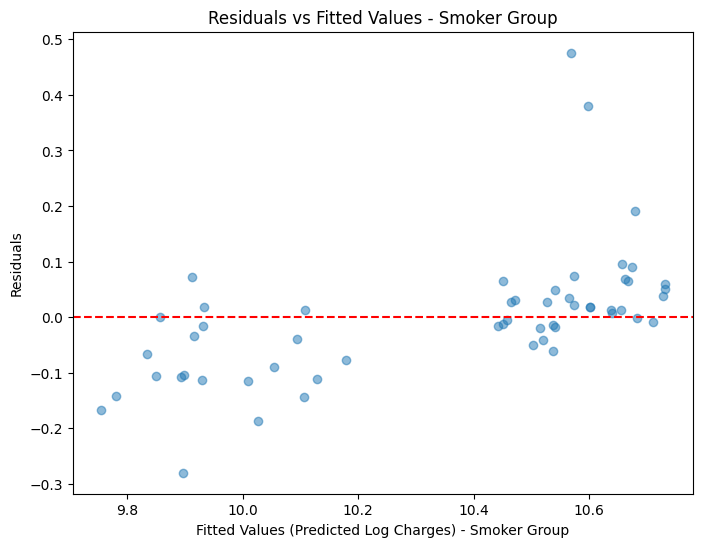

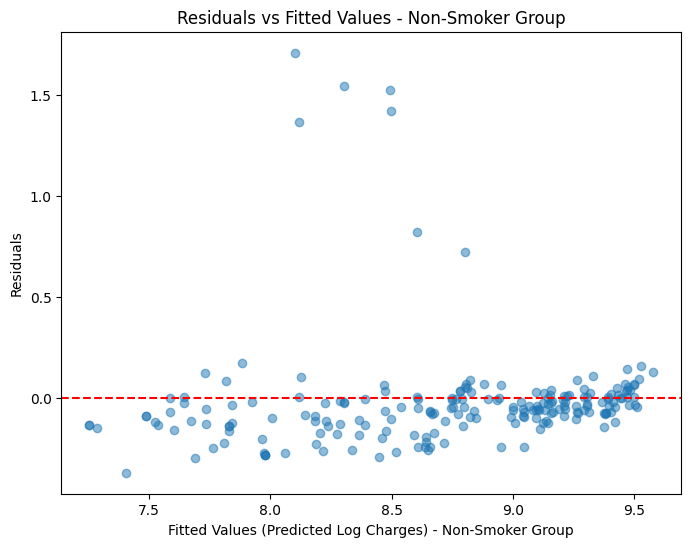

In [268]:
# plot the residuals vs fitted values for smoker and non-smoker groups separately
# smoker group
residuals_smoker = y_test_smoker - y_pred_xgb_smoker
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_smoker, residuals_smoker, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges) - Smoker Group')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - Smoker Group')
plt.show()
# non-smoker group
residuals_non_smoker = y_test_non_smoker - y_pred_xgb_non_smoker
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_non_smoker, residuals_non_smoker, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges) - Non-Smoker Group')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - Non-Smoker Group')
plt.show()

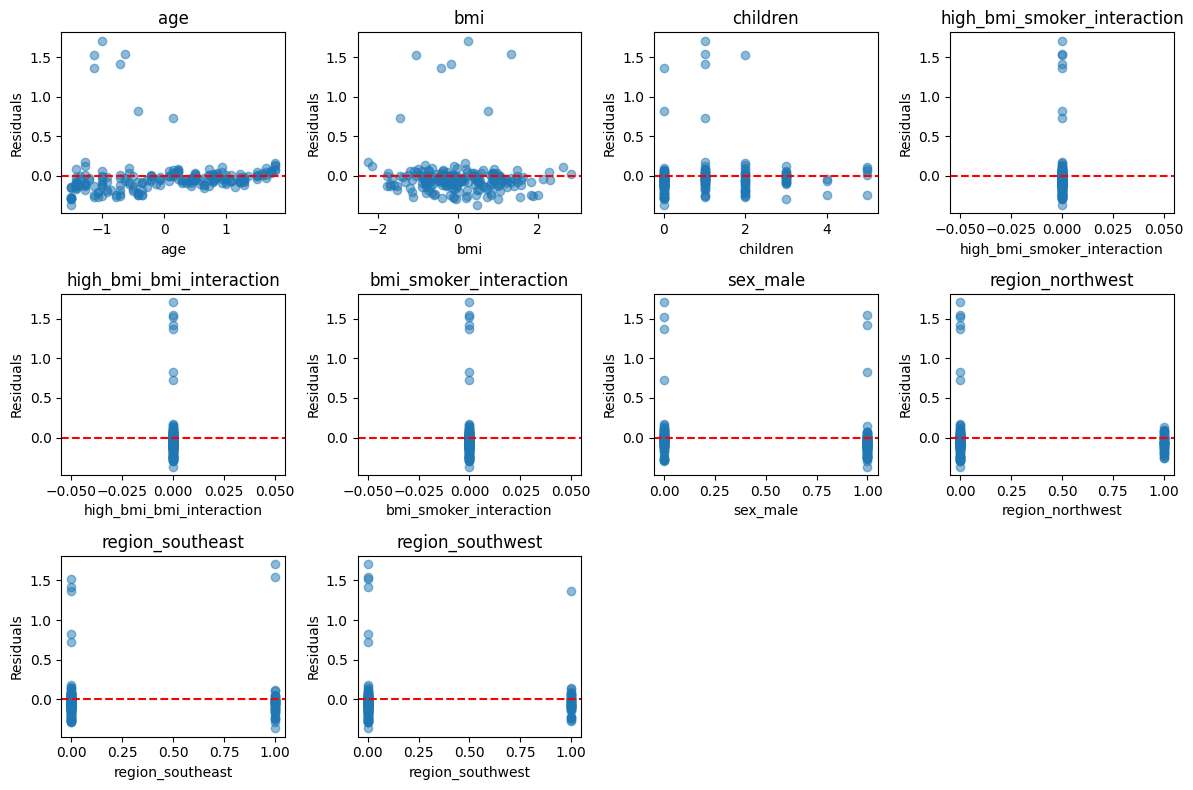

In [269]:
# Plot residuals vs each of the individual features
import matplotlib.pyplot as plt

# Get residuals
residuals = y_test_non_smoker - y_pred_xgb_non_smoker

# Plot residuals
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_test_non_smoker.columns):
    plt.subplot(3, 4, i + 1)
    plt.scatter(X_test_non_smoker[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


In [270]:
# Exploring higher order interactions (quadratic, cubic,...) for non-smoker group for age alone
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features for age up to degree 5
poly = PolynomialFeatures(degree=5, include_bias=False)
age_poly = poly.fit_transform(non_smoker_df[['age']])
age_poly_df = pd.DataFrame(age_poly, columns=[f'age_deg_{i}' for i in range(1, age_poly.shape[1] + 1)])
print(f'Age polynomial group shape: {age_poly_df.shape}')
# Add polynomial age features to non_smoker_df
non_smoker_df_poly = pd.concat([non_smoker_df.reset_index(drop=True), age_poly_df.reset_index(drop=True)], axis=1)
# Define features and target variable for non-smoker group with polynomial age features
X_non_smoker_poly = non_smoker_df_poly.drop(['age', 'age_deg_1','log_charges'], axis=1)
print(f'X_non_smoker_poly initial shape: {X_non_smoker_poly.shape}')
y_non_smoker_poly = non_smoker_df['log_charges']
print(f'y_non_smoker_poly shape: {y_non_smoker_poly.shape}')
# One-hot encode categorical variables
X_non_smoker_poly = pd.get_dummies(X_non_smoker_poly, drop_first=True)
# print dimensions of X_non_smoker_poly and y_non_smoker_poly
print(f'Non-smoker group shape: {non_smoker_df.shape}')
print(f'X_non_smoker_poly shape: {X_non_smoker_poly.shape}')
print(f'y_non_smoker_poly shape: {y_non_smoker_poly.shape}')
# Use train-test split
X_train_non_smoker_poly, X_test_non_smoker_poly, y_train_non_smoker_poly, y_test_non_smoker_poly = train_test_split(X_non_smoker_poly, y_non_smoker_poly, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for non-smoker group with polynomial age features
xgb_model_non_smoker_poly = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker_poly = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker_poly = GridSearchCV(estimator=xgb_model_non_smoker_poly, param_grid=param_grid_non_smoker_poly, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker_poly.fit(X_train_non_smoker_poly, y_train_non_smoker_poly)
best_xgb_non_smoker_poly = grid_search_xgb_non_smoker_poly.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group with polynomial age features
y_pred_xgb_non_smoker_poly = best_xgb_non_smoker_poly.predict(X_test_non_smoker_poly)
# Evaluate the XGBoost model for non-smoker group with polynomial age features
mse_xgb_non_smoker_poly = mean_squared_error(y_test_non_smoker_poly, y_pred_xgb_non_smoker_poly)
r2_xgb_non_smoker_poly = r2_score(y_test_non_smoker_poly, y_pred_xgb_non_smoker_poly)
print(f'XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features: {mse_xgb_non_smoker_poly}')
print(f'XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features: {r2_xgb_non_smoker_poly}')


Age polynomial group shape: (1018, 5)
X_non_smoker_poly initial shape: (1018, 12)
y_non_smoker_poly shape: (1018,)
Non-smoker group shape: (1018, 10)
X_non_smoker_poly shape: (1018, 13)
y_non_smoker_poly shape: (1018,)
XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features: 0.07354188768015528
XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features: 0.8366274676705994


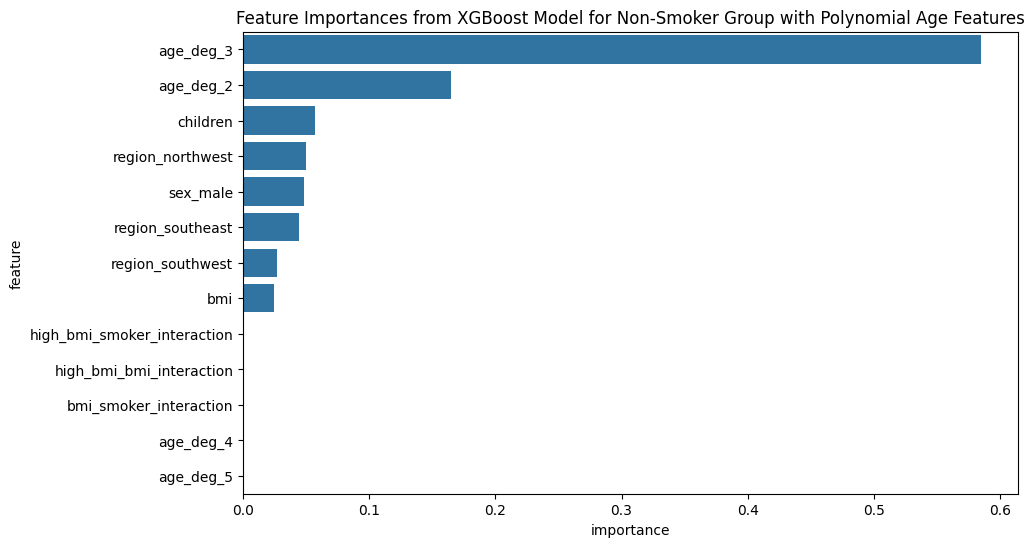

In [271]:
# get feature importances from the best_xgb_non_smoker_poly model
feature_importances = best_xgb_non_smoker_poly.feature_importances_
# create a dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': X_non_smoker_poly.columns, 'importance': feature_importances})
# sort the dataframe by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
# plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances from XGBoost Model for Non-Smoker Group with Polynomial Age Features')
plt.show()

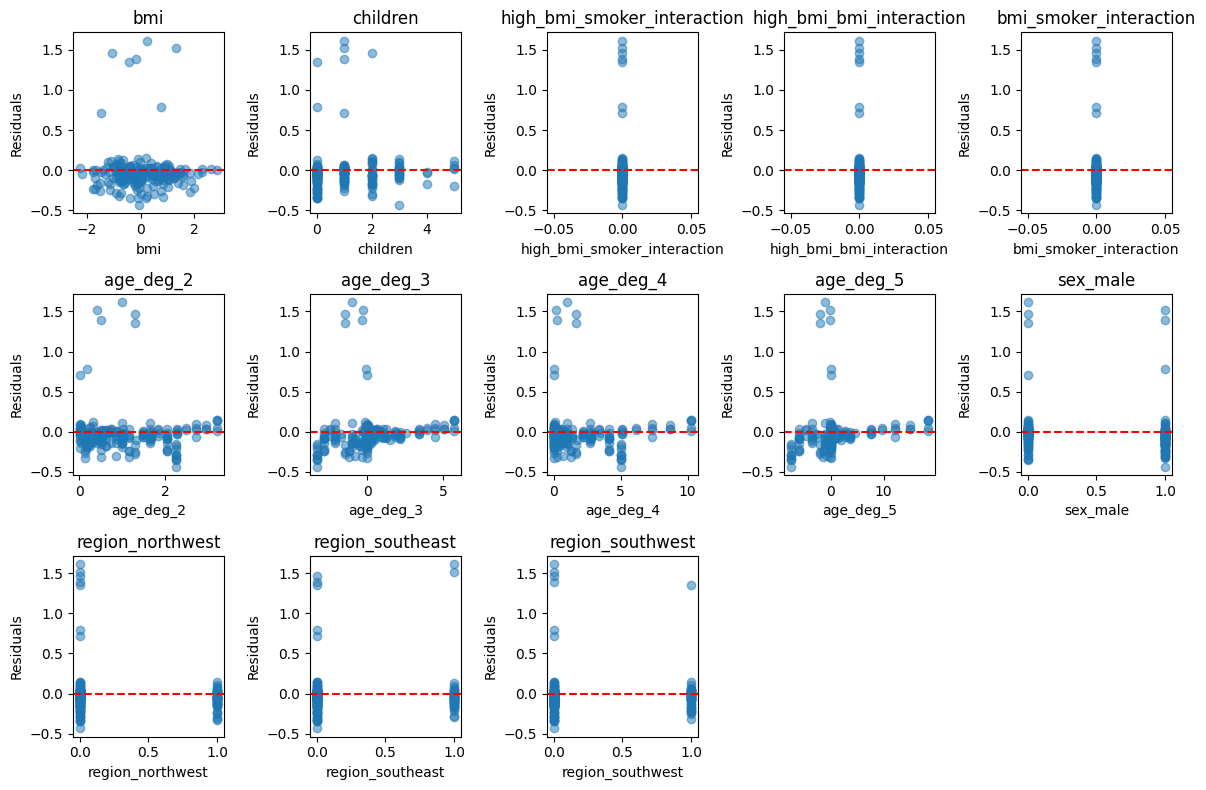

In [272]:
# Plot residuals vs each of the individual features
import matplotlib.pyplot as plt

# Get residuals
residuals = y_test_non_smoker_poly - y_pred_xgb_non_smoker_poly

# Plot residuals
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_test_non_smoker_poly.columns):
    plt.subplot(3, 5, i + 1)
    plt.scatter(X_test_non_smoker_poly[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


In [273]:
# Exploring higher order interactions (quadratic, cubic,...) for non-smoker group for bmi in addition to what was done for age
# Add a term for bmi>30 for overweight (adjusted for standardized bmi), add interaction terms between bmi and age polynomial features
# Create polynomial features for bmi up to degree 5
for i in range(1, 6):
    non_smoker_df_poly[f'bmi_deg_{i}'] = non_smoker_df_poly['bmi'] ** i
non_smoker_df_poly['high_bmi'] = (non_smoker_df_poly['bmi'] > (30 - data_df['bmi'].mean())/data_df['bmi'].std()).astype(int)
non_smoker_df_poly['high_bmi_bmi_interaction'] = non_smoker_df_poly['high_bmi'] * non_smoker_df_poly['bmi']
for i in range(1,6):
    non_smoker_df_poly[f'high_bmi_age_deg_{i}_interaction'] = non_smoker_df_poly['high_bmi'] * non_smoker_df_poly[f'age_deg_{i}']
# Define features and target variable for non-smoker group with polynomial age features and bmi interactions
X_non_smoker_poly = non_smoker_df_poly.drop(['age', 'age_deg_1','log_charges'], axis=1)
y_non_smoker_poly = non_smoker_df['log_charges']
# One-hot encode categorical variables
X_non_smoker_poly = pd.get_dummies(X_non_smoker_poly, drop_first=True)
# print dimensions of X_non_smoker_poly and y_non_smoker_poly
print(f'Non-smoker group shape: {non_smoker_df.shape}')
print(f'X_non_smoker_poly shape: {X_non_smoker_poly.shape}')
print(f'y_non_smoker_poly shape: {y_non_smoker_poly.shape}')
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X_non_smoker_poly, y_non_smoker_poly, test_size=0.2, random_state=42)

# Run XGBoost with hyperparameter tuning to find the best model for non-smoker group with polynomial age features and bmi interactions
xgb_model_non_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker = GridSearchCV(estimator=xgb_model_non_smoker, param_grid=param_grid_non_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker.fit(X_train, y_train)
best_xgb_non_smoker = grid_search_xgb_non_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group with polynomial age features and bmi interactions
y_pred_xgb_non_smoker = best_xgb_non_smoker.predict(X_test)
# Evaluate the XGBoost model for non-smoker group with polynomial age features and bmi interactions
mse_xgb_non_smoker = mean_squared_error(y_test, y_pred_xgb_non_smoker)
r2_xgb_non_smoker = r2_score(y_test, y_pred_xgb_non_smoker)
print(f'XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features and BMI Interactions: {mse_xgb_non_smoker}')
print(f'XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features and BMI Interactions: {r2_xgb_non_smoker}')

Non-smoker group shape: (1018, 10)
X_non_smoker_poly shape: (1018, 24)
y_non_smoker_poly shape: (1018,)
XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features and BMI Interactions: 0.07757479979674842
XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features and BMI Interactions: 0.8276683956922561


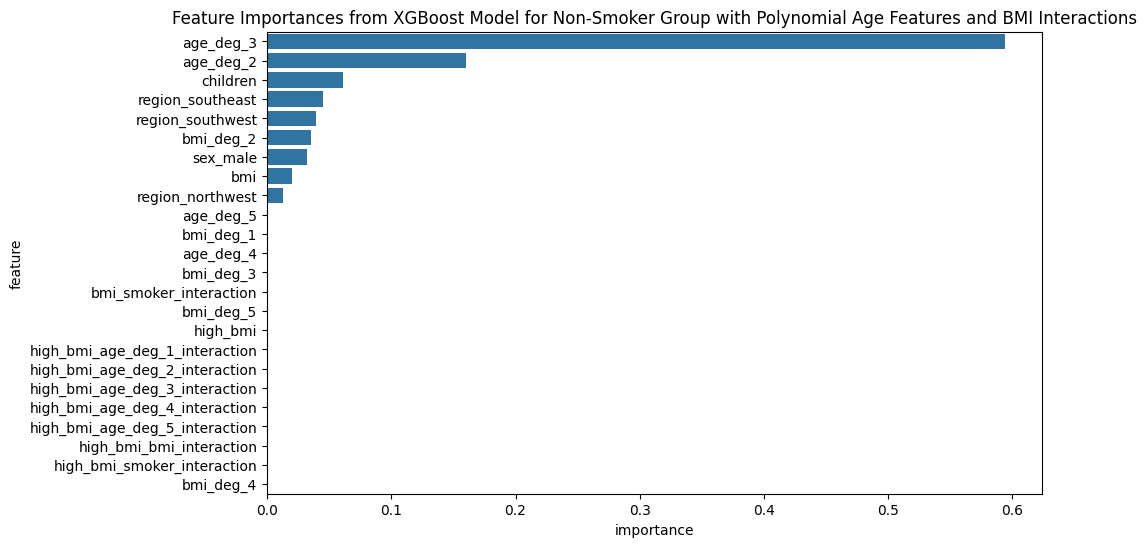

In [274]:
# get feature importances from the best_xgb_non_smoker_poly model
feature_importances = best_xgb_non_smoker.feature_importances_
# create a dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': X_test.columns, 'importance': feature_importances})
# sort the dataframe by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
# plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances from XGBoost Model for Non-Smoker Group with Polynomial Age Features and BMI Interactions')
plt.show()

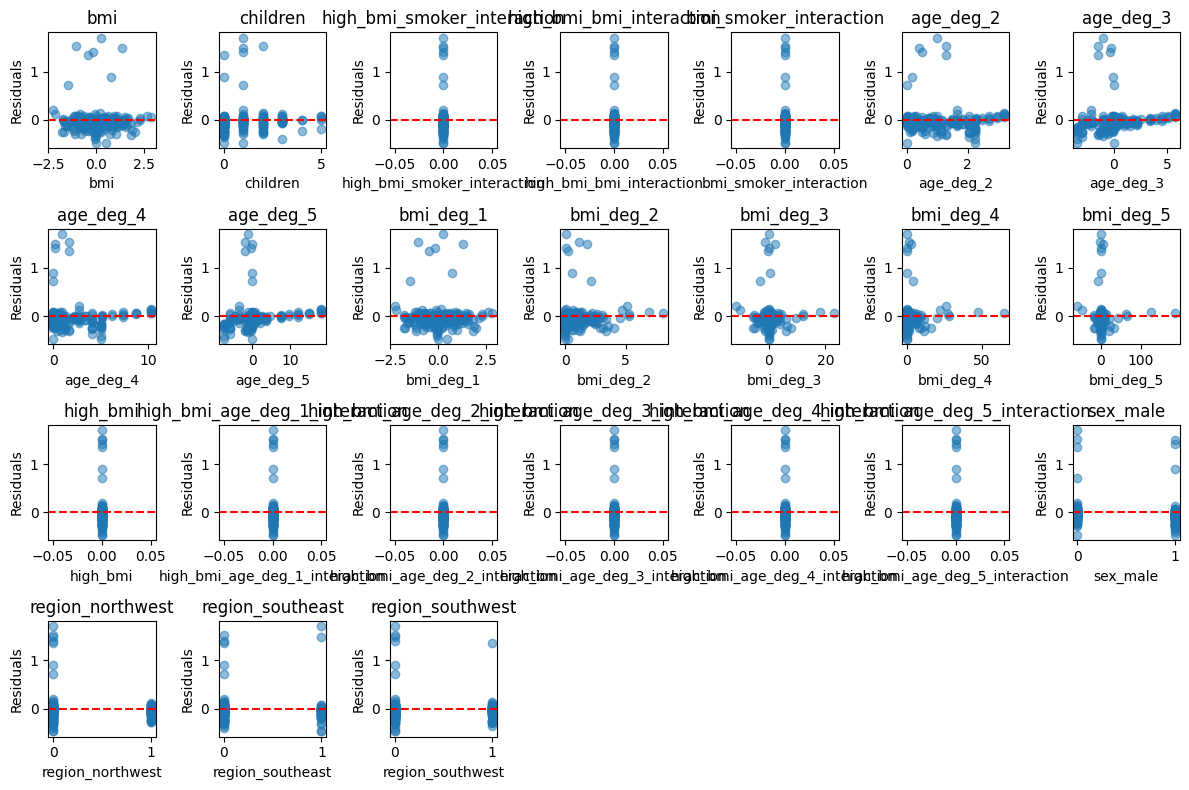

In [275]:
# plot residuals vs each of the individual features
import matplotlib.pyplot as plt
# Get residuals
residuals = y_test - y_pred_xgb_non_smoker
# Plot residuals
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_test.columns):
    plt.subplot(4, 7, i + 1)
    plt.scatter(X_test[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

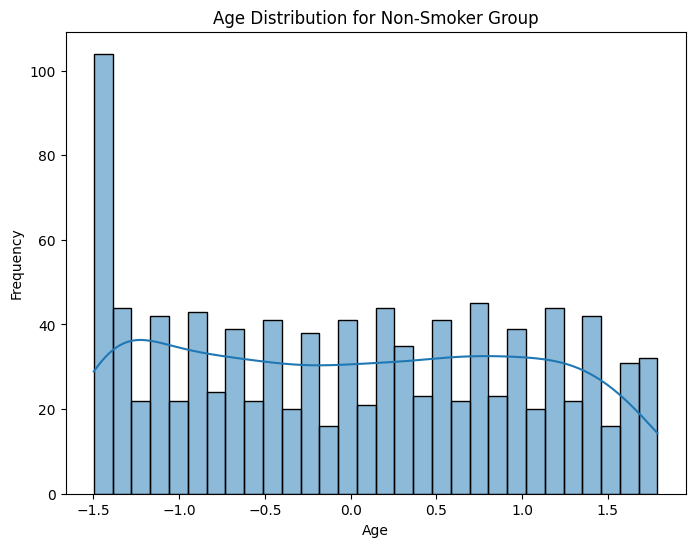

In [276]:
# See age distribution for non-smoker group
plt.figure(figsize=(8, 6))
sns.histplot(non_smoker_df['age'], bins=30, kde=True)
plt.title('Age Distribution for Non-Smoker Group')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

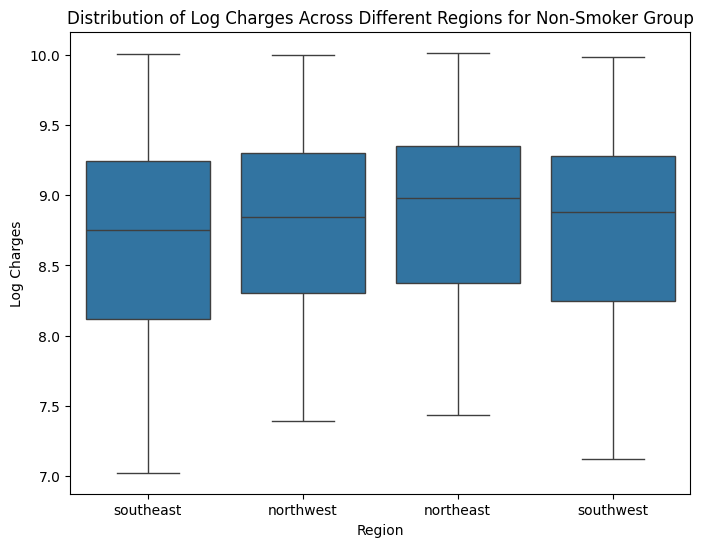

In [277]:
# distribution of charges across different regions for non-smoker group
plt.figure(figsize=(8, 6))
sns.boxplot(x='region', y='log_charges', data=non_smoker_df)
plt.title('Distribution of Log Charges Across Different Regions for Non-Smoker Group')
plt.xlabel('Region')
plt.ylabel('Log Charges')
plt.show()

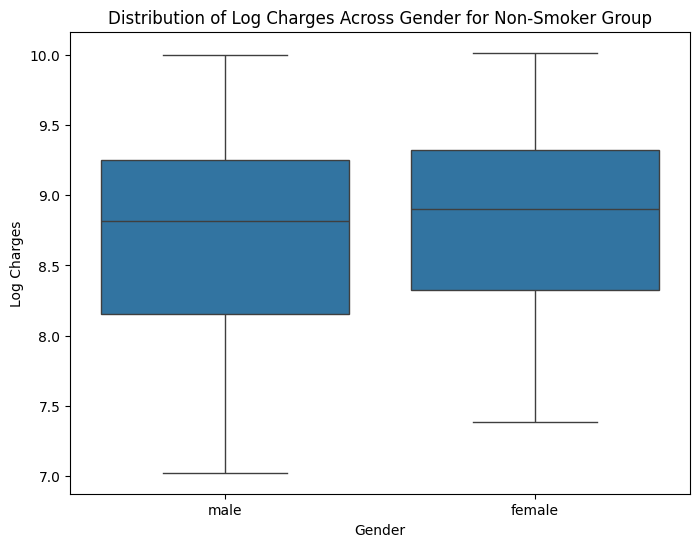

In [278]:
# distribution of charges across gender for non-smoker group
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='log_charges', data=non_smoker_df)
plt.title('Distribution of Log Charges Across Gender for Non-Smoker Group')
plt.xlabel('Gender')
plt.ylabel('Log Charges')
plt.show()

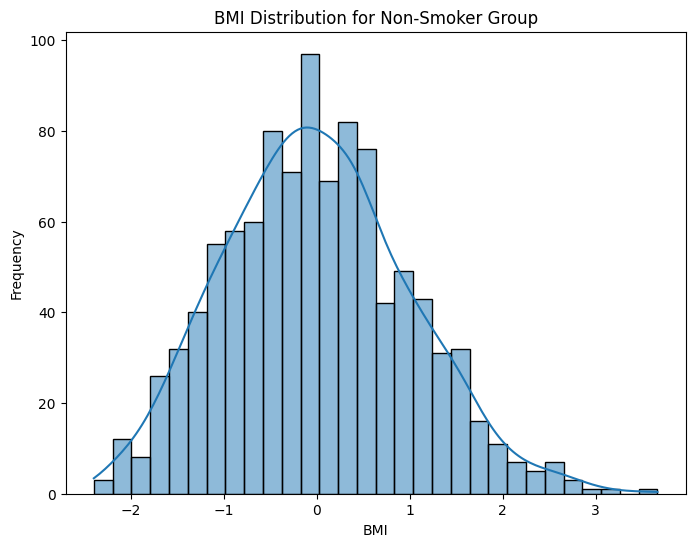

In [279]:
# distribution of bmi for non-smoker group
plt.figure(figsize=(8, 6))
sns.histplot(non_smoker_df['bmi'], bins=30, kde=True)
plt.title('BMI Distribution for Non-Smoker Group')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

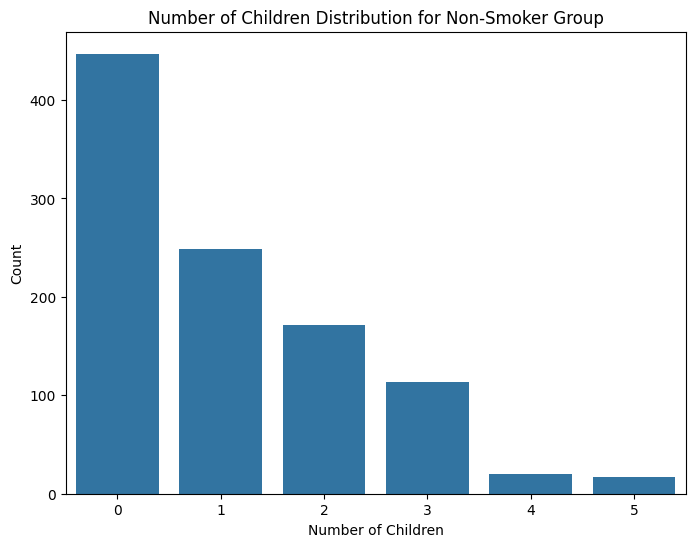

In [280]:
# distribution of number of children for non-smoker group
plt.figure(figsize=(8, 6))
sns.countplot(x='children', data=non_smoker_df)
plt.title('Number of Children Distribution for Non-Smoker Group')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

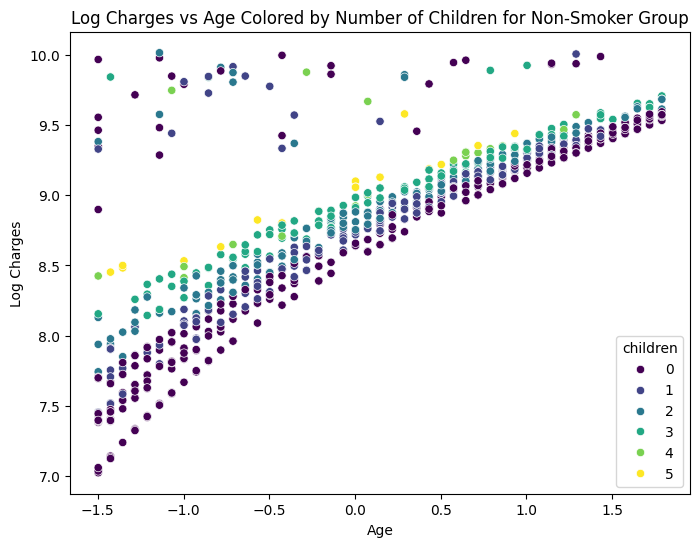

In [281]:
# Plot interaction between charges and age using number of children as hue for non-smoker group
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='log_charges', hue='children', data=non_smoker_df, palette='viridis')
plt.title('Log Charges vs Age Colored by Number of Children for Non-Smoker Group')
plt.xlabel('Age')
plt.ylabel('Log Charges')
plt.show()

/var/folders/yk/c0cfqj715njfdnphhzw8m5p00000gn/T/ipykernel_94286/3736124537.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=children_counts.index, y=children_counts.values, palette='viridis')


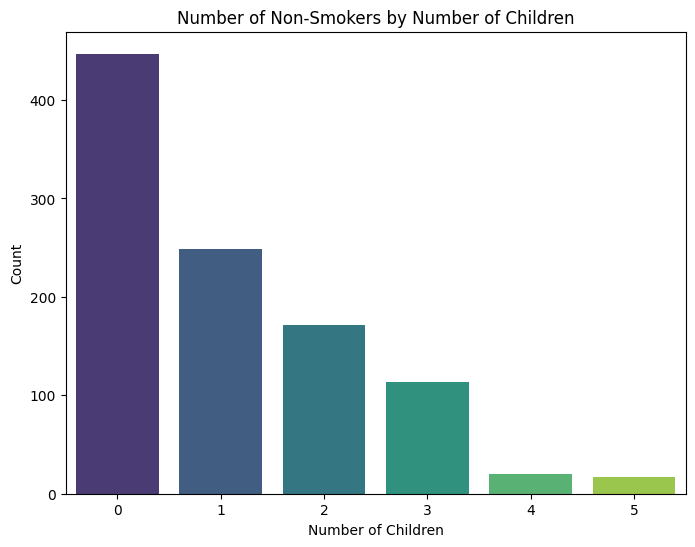

In [282]:
# Count number of non-smokers with n number of children
children_counts = non_smoker_df['children'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=children_counts.index, y=children_counts.values, palette='viridis')
plt.title('Number of Non-Smokers by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

In [283]:
# Create different models for number of children = 0 and number of children >=1 for non-smoker group
no_children_df = non_smoker_df[non_smoker_df['children'] == 0]
has_children_df = non_smoker_df[non_smoker_df['children'] >= 1]
# Define features and target variable for no children group
X_no_children = no_children_df.drop('log_charges', axis=1)
y_no_children = no_children_df['log_charges']
# One-hot encode categorical variables
X_no_children = pd.get_dummies(X_no_children, drop_first=True)
# Use train-test split
X_train_no_children, X_test_no_children, y_train_no_children, y_test_no_children = train_test_split(X_no_children, y_no_children, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for no children group
xgb_model_no_children = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_no_children = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_no_children = GridSearchCV(estimator=xgb_model_no_children, param_grid=param_grid_no_children, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_no_children.fit(X_train_no_children, y_train_no_children)
best_xgb_no_children = grid_search_xgb_no_children.best_estimator_
# Predict on the test data using the best XGBoost model for no children group
y_pred_xgb_no_children = best_xgb_no_children.predict(X_test_no_children)
# Evaluate the XGBoost model for no children group
mse_xgb_no_children = mean_squared_error(y_test_no_children, y_pred_xgb_no_children)
r2_xgb_no_children = r2_score(y_test_no_children, y_pred_xgb_no_children)
print(f'XGBoost Test MSE for Non-Smoker Group with No Children: {mse_xgb_no_children}')
print(f'XGBoost Test R2 for Non-Smoker Group with No Children: {r2_xgb_no_children}')   

# Define features and target variable for has children group
X_has_children = has_children_df.drop('log_charges', axis=1)
y_has_children = has_children_df['log_charges']
# One-hot encode categorical variables
X_has_children = pd.get_dummies(X_has_children, drop_first=True)        
# Use train-test split
X_train_has_children, X_test_has_children, y_train_has_children, y_test_has_children = train_test_split(X_has_children, y_has_children, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for has children group
xgb_model_has_children = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_has_children = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_has_children = GridSearchCV(estimator=xgb_model_has_children, param_grid=param_grid_has_children, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_has_children.fit(X_train_has_children, y_train_has_children)
best_xgb_has_children = grid_search_xgb_has_children.best_estimator_
# Predict on the test data using the best XGBoost model for has children group
y_pred_xgb_has_children = best_xgb_has_children.predict(X_test_has_children)
# Evaluate the XGBoost model for has children group
mse_xgb_has_children = mean_squared_error(y_test_has_children, y_pred_xgb_has_children)
r2_xgb_has_children = r2_score(y_test_has_children, y_pred_xgb_has_children)
print(f'XGBoost Test MSE for Non-Smoker Group with Children: {mse_xgb_has_children}')
print(f'XGBoost Test R2 for Non-Smoker Group with Children: {r2_xgb_has_children}')

XGBoost Test MSE for Non-Smoker Group with No Children: 0.20042663607755556
XGBoost Test R2 for Non-Smoker Group with No Children: 0.6925920726447672
XGBoost Test MSE for Non-Smoker Group with Children: 0.10723468733503398
XGBoost Test R2 for Non-Smoker Group with Children: 0.6233463439192806
